In [1]:
import sympy as sym
import autograd.numpy as np
import matplotlib.pyplot as plt

# import autograd ’s automatic differentiator
import autograd as ag

# datapath to data
datapath = '/home/michaelrencheck/EE475/machine_learning_refined-gh-pages/mlrefined_exercises/ed_2/mlrefined_datasets/superlearn_datasets/'

sym.init_printing()

# Function to standard normalize data
def std_normalize(in_arr):
    u = np.mean(in_arr, axis=1)
    sig = np.std(in_arr, axis=1)
        
    out = np.zeros(in_arr.shape)
    
    for i, row in enumerate(in_arr):       
        for j, element in enumerate(row):
            out[i,j] = (element - u[i])/ sig[i]
            
    return np.squeeze(out)

In [2]:
from sklearn.datasets import fetch_openml
# import MNIST
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# re-shape input/output data
x = x.T
y = np.array([int(v) for v in y])[np.newaxis,:]

print(np.shape(x))
print(np.shape(y))

(784, 70000)
(1, 70000)


In [3]:
# normalize each picture
for i in range(x.shape[1]):
    x[:,i] = x[:,i] / np.linalg.norm(x[:,i])

trainingx = x[:,0:50000]
trainingy = y[:,0:50000]

testingx = x[:,50000:]
testingy = y[:,50000:]

# Preappend the ones to the data sets:
trainingx = np.vstack([np.ones(trainingx.shape[1]),trainingx])
testingx = np.vstack([np.ones(testingx.shape[1]),testingx])

print(np.shape(trainingx))
print(np.shape(trainingy))

print(np.shape(testingx))
print(np.shape(testingy))

(785, 50000)
(1, 50000)
(785, 20000)
(1, 20000)


In [4]:
def multiclass_softmax(wi, xin, yin):
    """
    wi - weights
    xin - input data
    yin - output labels
    """
    # compute predictions on all points
    all_evals = np.dot(xin.T, wi)   
    all_evals = all_evals.T
    
    # Finds xp.T * w_yp for each data point based on the output associated to each input
    b = all_evals[yin.astype(int).flatten(), np.arange(np.size(yin))]

    # subtract the xp.T*w_yp value from all xp.T * w_j values
    # find the max xp.T * w_j for each data point    
    a = (all_evals - b)

    # take the exponent of each xp.T (w_j - w_yp)
    a = np.exp(a)   
    
    # sum each column
    a_sum = a.sum(axis=0)
    
    # take the log of 1+sum for each data point
    a_sum = np.log(1 + a_sum)
    
    # return the average cost
    return np.sum(a_sum) / float(np.size(yin))

def mini_batch_gd(func, w0, data_x, data_y, epochs, alpha, mini_batch_size):
    """
    func- cost function
    w0 - initial guess
    data_x - training data with a 1 already appended to it
    data_y - training data
    epochs - number of full iterations
    alpah - learning rate
    mini_batch_size - the size of each batch to parse the data with
    
    The mini batch size should fit evenly in to the number of data points
    """
    dfunc = ag.grad(func)
    
    w = np.copy(w0)
    
    weight_history = [np.copy(w)] # weight history container
    cost_history = [func(w,data_x,data_y)] # cost function history container
    
    miss_history = [] #misclassification histroy container
    
    num_batches = int(data_y.shape[1]/mini_batch_size)
    
    for i in range(epochs):
        
        # Use mini batches to compute each w and cost
        for j in range(num_batches-1):
                        
            x_seg = data_x[:, mini_batch_size * (j) : mini_batch_size * (j+1)]
            y_seg = data_y[:, mini_batch_size * (j) : mini_batch_size * (j+1)]
            
            grad_res = dfunc(w, x_seg, y_seg)
                       
            w -= alpha*grad_res
        
        cost_history.append(func(w, data_x, data_y))
        weight_history.append(np.copy(w))
        
        test = np.dot(data_x.T, w)
        misclass = test.argmax(axis=1)
        miss_history.append(np.sum(misclass != trainingy[0]))        
        print("Completed Epoch: ", i)
        
    return cost_history, weight_history, miss_history, w


In [17]:
epochs = 30
alpha = 3e-1
batch_n = 200

C = 10 # numbers 0 through 9

w_init = np.ones([trainingx.shape[0], C])

cost_raw, ws_raw, misses_raw, w_raw = mini_batch_gd(multiclass_softmax, w_init, trainingx, trainingy, epochs, alpha, batch_n)

Completed Epoch:  0
Completed Epoch:  1
Completed Epoch:  2
Completed Epoch:  3
Completed Epoch:  4
Completed Epoch:  5
Completed Epoch:  6
Completed Epoch:  7
Completed Epoch:  8
Completed Epoch:  9
Completed Epoch:  10
Completed Epoch:  11
Completed Epoch:  12
Completed Epoch:  13
Completed Epoch:  14
Completed Epoch:  15
Completed Epoch:  16
Completed Epoch:  17
Completed Epoch:  18
Completed Epoch:  19
Completed Epoch:  20
Completed Epoch:  21
Completed Epoch:  22
Completed Epoch:  23
Completed Epoch:  24
Completed Epoch:  25
Completed Epoch:  26
Completed Epoch:  27
Completed Epoch:  28
Completed Epoch:  29


In [6]:
# Perform convolution for vertical and horizonal kernals on each image to perform edge detection 
# Break each image into 9 3X3 blocks and ignore the last row and column of pixels giving us 81 blocks per image

# edge detection kernals
horz_kernel = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
vert_kernel = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])

# histogram bins
bins = np.array([0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5])

# initialize the new training dataset
trainingx_hist = np.zeros([81*len(bins), trainingx.shape[1]])

for pic_id in range(trainingx.shape[1]):
    
    # reshape the data into the shape of the picture
    picture = trainingx[1:, pic_id].reshape(28,28)
    
    # feature data for the 81 blocks in a photo
    picture_hist = np.zeros([81,len(bins)])
    
    for i in range(9):
        # y coords for a block
        ys = 3*i
        ye = 3*(i+1)

        for j in range(9):
            # x coords for a block
            xs= 3*j
            xe= 3*(j+1)     

            # extract the block
            block = picture[xs:xe, ys:ye]

            # Convolve the block
            xcomp = np.sum(np.multiply(block, horz_kernel))
            ycomp = np.sum(np.multiply(block, vert_kernel))

            # clac the block index
            block_num = i*9 + j

            # skip over all blocks that have no edges or calculate the angle of the vector
            if(xcomp == 0 and ycomp == 0):
                pass
            else:
                # find the angle of the vector
                ang = np.arctan2(ycomp,xcomp)

                # make all angles positive
                if ang < 0:
                    ang += np.pi

                # convert to degrees
                ang = (ang * 360) / (2*np.pi)

                # find the closest angle and get the index of it in the histogram
                picture_hist[block_num, np.argmin(np.abs(bins - ang))] = 1
            

    trainingx_hist[:, pic_id] = np.copy(picture_hist.flatten())

print(trainingx_hist.shape)

(648, 50000)


In [23]:
testingx_hist = np.zeros([81*len(bins), testingx.shape[1]])

for pic_id in range(testingx.shape[1]):
    
    # reshape the data into the shape of the picture
    picture = testingx[1:, pic_id].reshape(28,28)
    
    # feature data for the 81 blocks in a photo
    picture_hist = np.zeros([81,len(bins)])
    
    for i in range(9):
        # y coords for a block
        ys = 3*i
        ye = 3*(i+1)

        for j in range(9):
            # x coords for a block
            xs= 3*j
            xe= 3*(j+1)     

            # extract the block
            block = picture[xs:xe, ys:ye]

            # Convolve the block
            xcomp = np.sum(np.multiply(block, horz_kernel))
            ycomp = np.sum(np.multiply(block, vert_kernel))

            # clac the block index
            block_num = i*9 + j

            # skip over all blocks that have no edges or calculate the angle of the vector
            if(xcomp == 0 and ycomp == 0):
                pass
            else:
                # find the angle of the vector
                ang = np.arctan2(ycomp,xcomp)

                # make all angles positive
                if ang < 0:
                    ang += np.pi

                # convert to degrees
                ang = (ang * 360) / (2*np.pi)

                # find the closest angle and get the index of it in the histogram
                picture_hist[block_num, np.argmin(np.abs(bins - ang))] = 1
            

    testingx_hist[:, pic_id] = np.copy(picture_hist.flatten())

print(testingx_hist.shape)

(648, 20000)


In [14]:
epochs = 30
alpha = 3e-1
batch_n = 200

C = 10 # numbers 0 through 9

w_init = np.ones([trainingx_hist.shape[0], C])

cost_hist, ws_hist, misses_hist, w_hist = mini_batch_gd(multiclass_softmax, w_init, trainingx_hist, trainingy, epochs, alpha, batch_n)

Completed Epoch:  0
Completed Epoch:  1
Completed Epoch:  2
Completed Epoch:  3
Completed Epoch:  4
Completed Epoch:  5
Completed Epoch:  6
Completed Epoch:  7
Completed Epoch:  8
Completed Epoch:  9
Completed Epoch:  10
Completed Epoch:  11
Completed Epoch:  12
Completed Epoch:  13
Completed Epoch:  14
Completed Epoch:  15
Completed Epoch:  16
Completed Epoch:  17
Completed Epoch:  18
Completed Epoch:  19
Completed Epoch:  20
Completed Epoch:  21
Completed Epoch:  22
Completed Epoch:  23
Completed Epoch:  24
Completed Epoch:  25
Completed Epoch:  26
Completed Epoch:  27
Completed Epoch:  28
Completed Epoch:  29


Training Process Results


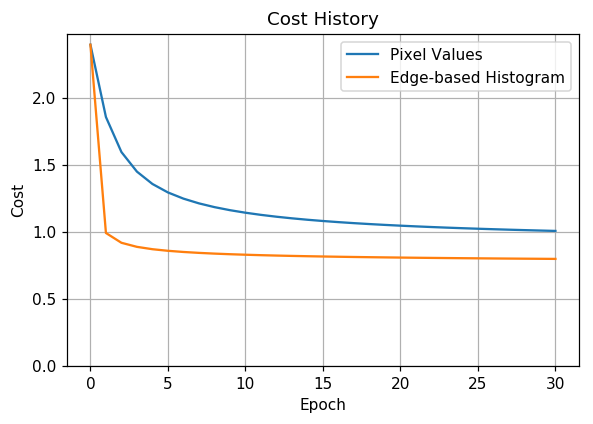

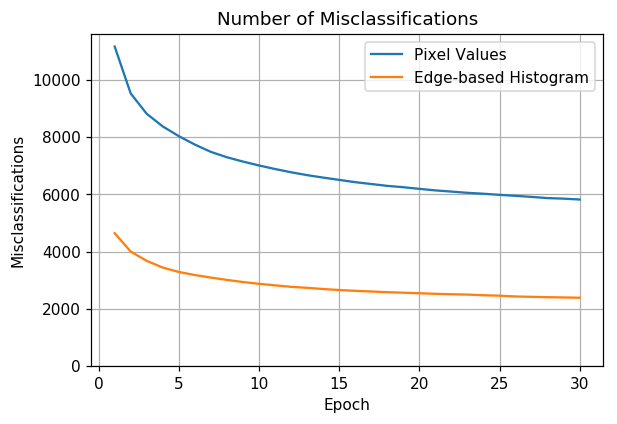

In [19]:
print("Training Process Results")

fig1 = plt.figure(dpi=110,facecolor='w')
plt.grid(True)
plt.plot(np.arange(len(cost_raw)),cost_raw)
plt.plot(np.arange(len(cost_hist)),cost_hist)
plt.title("Cost History")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.ylim(ymin=0)
plt.legend(["Pixel Values", "Edge-based Histogram"])

fig1 = plt.figure(dpi=110,facecolor='w')
plt.grid(True)
plt.plot(np.arange(len(misses_raw))+1,misses_raw)
plt.plot(np.arange(len(misses_hist))+1,misses_hist)
plt.title("Number of Misclassifications")
plt.xlabel("Epoch")
plt.ylabel("Misclassifications")
plt.legend(["Pixel Values", "Edge-based Histogram"])
plt.ylim(ymin=0)
plt.show()

In [28]:
print("Misclassifications of Testing Data for Final Weights:")
test = np.dot(testingx.T, w_raw)
misclass = test.argmax(axis=1)
print("Pixel Values: \t\t", np.sum(misclass != testingy[0])) 

test = np.dot(testingx_hist.T, w_hist)
misclass = test.argmax(axis=1)
print("Edge-based Histogram: \t", np.sum(misclass != testingy[0])) 


Misclassifications of Testing Data for Final Weights:
Pixel Values: 		 2091
Edge-based Histogram: 	 992
